In [2]:
%%capture
!pip install ase
!pip install pymatgen
!pip install -q orb-models
!pip install orb-models
!pip install --extra-index-url=https://pypi.nvidia.com "cuml-cu12==25.2.*"  # For cuda versions >=12.0, <13.0
!pip install orb-models ase tqdm matplotlib numpy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading ORB model on device: cuda


/usr/local/lib/python3.11/dist-packages/orb_models/utils.py:30: UserWarning: Setting global torch default dtype to torch.float32.
  warnings.warn(f"Setting global torch default dtype to {torch_dtype}.")


ORB model loaded successfully
Loading Alexandria dataset from: /content/drive/MyDrive/AML/alexandria_000.json.bz2


Processing structures:  90%|████████▉ | 89834/100000 [00:51<00:04, 2109.88it/s]/usr/local/lib/python3.11/dist-packages/pymatgen/core/composition.py:1365: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  syms: list[str] = sorted(sym_amt, key=lambda x: [get_el_sp(x).X, x])
Processing structures: 100%|██████████| 100000/100000 [00:57<00:00, 1733.22it/s]


Loaded 100000 structures with energies


Predicting energies: 100%|██████████| 100000/100000 [23:33<00:00, 70.72it/s]


Computed formation energies for 100000 valid structures
Performance Metrics:
  Mean Absolute Error (MAE): 0.0256 eV/atom
  R² Score: 0.9434
Saving results to: /content/drive/MyDrive/AML/Results/energy_predictions_ORB.tsv
Plot saved to: /content/drive/MyDrive/AML/Results/formation_energy_prediction_ORB.png


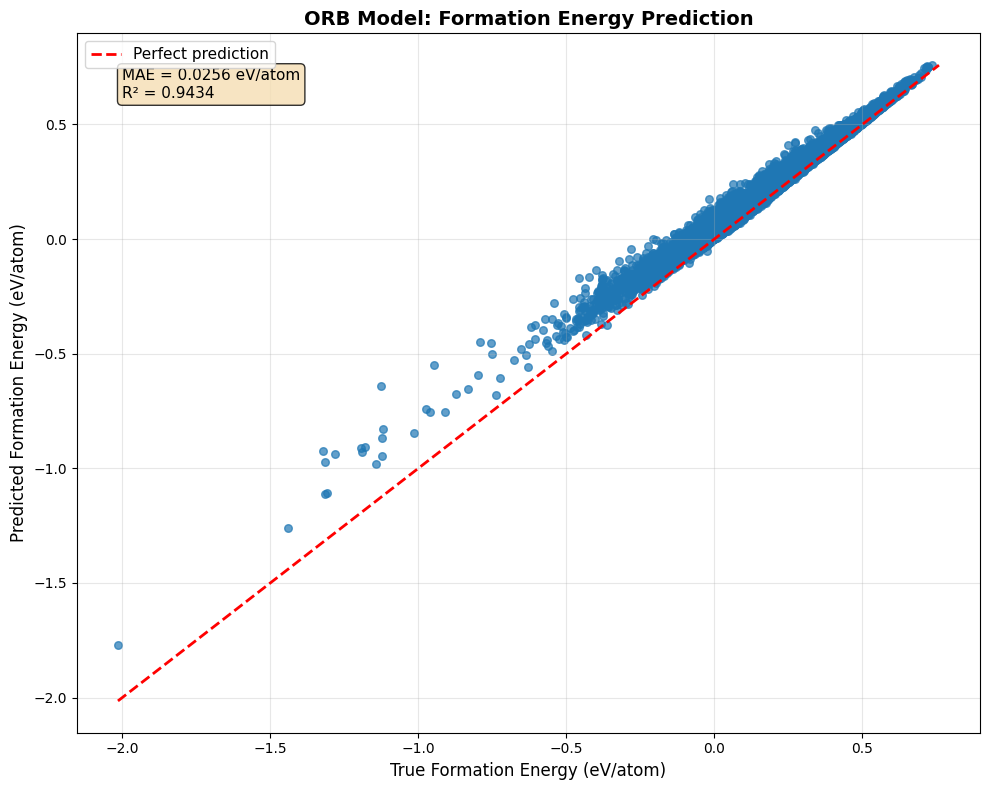

Analysis completed successfully!


In [4]:
#!/usr/bin/env python3
"""
Materials Formation Energy Prediction using ORB Model
=====================================================

This script predicts formation energies of materials using the ORB model
and compares them with true values from the Alexandria dataset.

Author: Your Name
Date: 2025
"""

import json
import bz2
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
from typing import List, Tuple, Optional, Dict, Any

# Core libraries
from ase import Atoms
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Materials science libraries
from pymatgen.core import Composition, Structure
from pymatgen.ext.matproj import MPRester

# ORB model libraries
from orb_models.forcefield import pretrained
from orb_models.forcefield.calculator import ORBCalculator


class FormationEnergyPredictor:
    """
    A class to predict formation energies using the ORB model.
    """

    def __init__(self, api_key: str, device: str = None):
        """
        Initialize the predictor.

        Args:
            api_key: Materials Project API key
            device: Device to run calculations on ('cuda' or 'cpu')
        """
        self.api_key = api_key
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.mpr = MPRester(api_key)

        # Element reference energies (eV)
        self.element_refs = self._get_element_references()

        # Initialize ORB model
        self.orb_model = None
        self.calc = None

    def _get_element_references(self) -> Dict[str, float]:
        """Get elemental reference energies."""
        return {
            'H': -3.45511240125, 'He': -0.31390057, 'Li': -2.386706413333333,
            'Be': -3.7394128650000003, 'B': -7.346354197499999, 'C': -9.94723519,
            'N': -9.12875067125, 'O': -5.97253365125, 'F': -3.12602795,
            'Ne': -1.91282416, 'Na': -3.56418057, 'Mg': -4.169303585,
            'Al': -6.73209833, 'Si': -8.773764595, 'P': -9.00207631202381,
            'S': -8.0340372271875, 'Cl': -6.1524388975, 'Ar': -4.85851485,
            'K': -6.01826393625, 'Ca': -7.0382937, 'Sc': -11.398487355,
            'Ti': -12.937757013333334, 'V': -14.08957573, 'Cr': -15.07334239,
            'Mn': -14.683334675517242, 'Fe': -8.47002121, 'Co': -13.23423113,
            'Ni': -11.98171716, 'Cu': -10.846796, 'Zn': -8.910602605,
            'Ga': -11.44277595, 'Ge': -13.87197758, 'As': -14.7075309875,
            'Se': -14.3115602309375, 'Br': -13.2588797625, 'Kr': -12.584469843333332,
            'Rb': -0.9805340725, 'Sr': -15.14566107, 'Y': -20.31360096,
            'Zr': -22.749791905, 'Nb': -24.73407465, 'Mo': -26.07197944,
            'Tc': -25.96466205, 'Ru': -25.424535295, 'Rh': -24.13622863,
            'Pd': -22.960453610000002, 'Ag': -21.355877145, 'Cd': -20.10498769,
            'In': -22.57859038, 'Sn': -24.74618378, 'Sb': -25.70631573,
            'Te': -25.417224309999998, 'I': -24.5586837725, 'Xe': -0.03617417,
            'Cs': -25.108453, 'Ba': -1.91897494, 'La': -29.744780205,
            'Ce': -30.84062876, 'Pr': 0.008044545, 'Nd': -29.4180089825,
            'Pm': -29.5406124625, 'Sm': -29.73292432, 'Eu': -38.520882715,
            'Gd': -43.397005300000004, 'Tb': -31.22643415, 'Dy': -31.981803225,
            'Ho': -32.881343915, 'Er': -33.925435166666674, 'Tm': -35.12104829,
            'Yb': -36.529378785, 'Lu': -38.07988018333334, 'Hf': -45.15141539,
            'Ta': -48.591832712666665, 'W': -51.36779438, 'Re': -52.4106147075,
            'Os': -52.98522885, 'Ir': -52.35935345, 'Pt': -51.4877169,
            'Au': -50.58496015, 'Hg': 0.0008525383333330001, 'Tl': -53.17930458,
            'Pb': -56.28513411, 'Bi': -58.502273745, 'Ac': -68.6374794125,
            'Th': -73.47526215, 'Pa': -76.85601818, 'U': -79.942036625,
            'Np': -83.02421153125, 'Pu': -86.35634815125
        }

    def load_orb_model(self):
        """Load the pretrained ORB model."""
        print(f"Loading ORB model on device: {self.device}")
        self.orb_model = pretrained.orb_mptraj_only_v2()
        self.calc = ORBCalculator(model=self.orb_model, device=self.device)
        print("ORB model loaded successfully")

    def load_alexandria_data(self, file_path: str) -> Tuple[List[Atoms], List[float], List[str]]:
        """
        Load and process Alexandria dataset.

        Args:
            file_path: Path to the Alexandria dataset file

        Returns:
            Tuple of (atoms_list, true_energies, formulas)
        """
        print(f"Loading Alexandria dataset from: {file_path}")

        with bz2.open(file_path, 'rt') as f:
            data = json.load(f)

        atoms_list = []
        true_energies = []
        formulas = []

        for conformer in tqdm(data['entries'], desc="Processing structures"):
            # Rebuild structure
            structure = Structure.from_dict(conformer['structure'])
            formula = structure.composition.reduced_formula
            formulas.append(formula)

            # Convert to ASE Atoms
            atoms = Atoms(
                numbers=[site.specie.number for site in structure.sites],
                positions=[site.coords for site in structure.sites]
            )

            # Get energy if available
            energy = conformer.get('energy', None)
            if energy is None:
                continue  # skip if no energy

            atoms.info['energy'] = energy

            # Store stress (optional)
            stress = conformer['data'].get('stress', None)
            if stress is not None:
                atoms.info['stress'] = np.array(stress)

            atoms_list.append(atoms)
            true_energies.append(energy)

        print(f"Loaded {len(atoms_list)} structures with energies")
        return atoms_list, true_energies, formulas

    def predict_energies(self, atoms_list: List[Atoms]) -> List[float]:
        """
        Predict energies using the ORB model.

        Args:
            atoms_list: List of ASE Atoms objects

        Returns:
            List of predicted energies
        """
        if self.calc is None:
            raise ValueError("ORB model not loaded. Call load_orb_model() first.")

        predicted_energies = []
        for atoms in tqdm(atoms_list, desc="Predicting energies"):
            atoms.calc = self.calc
            pred_e = atoms.get_potential_energy()
            predicted_energies.append(pred_e)

        return predicted_energies

    @staticmethod
    def kjmol_to_ev(kjmol: float) -> float:
        """Convert kJ/mol to eV."""
        return kjmol * 0.010364

    def compute_formation_energy(self, total_energy: float, formula: str) -> Optional[float]:
        """
        Compute formation energy per atom.

        Args:
            total_energy: Total energy of the structure
            formula: Chemical formula

        Returns:
            Formation energy per atom in eV, or None if unknown elements
        """
        comp = Composition(formula)

        # Check if all elements are known
        for el in comp.get_el_amt_dict().keys():
            if el not in self.element_refs:
                return None  # Skip if unknown element found

        # Compute formation energy
        ref_energy = sum(n * self.element_refs[el]
                        for el, n in comp.get_el_amt_dict().items())
        formation_energy = total_energy - ref_energy

        return self.kjmol_to_ev(formation_energy / comp.num_atoms)

    def process_formation_energies(self, true_energies: List[float],
                                 predicted_energies: List[float],
                                 formulas: List[str]) -> Tuple[List[float], List[float], List[int]]:
        """
        Compute formation energies for all structures.

        Returns:
            Tuple of (predicted_form_energies, true_form_energies, valid_indices)
        """
        predicted_form_energies = []
        true_form_energies = []
        valid_indices = []

        for i, (true_e, pred_e, formula) in enumerate(zip(true_energies, predicted_energies, formulas)):
            pred_f = self.compute_formation_energy(pred_e, formula)
            true_f = self.compute_formation_energy(true_e, formula)

            # Only store if formation energy computed successfully
            if pred_f is not None and true_f is not None:
                predicted_form_energies.append(pred_f)
                true_form_energies.append(true_f)
                valid_indices.append(i)

        print(f"Computed formation energies for {len(valid_indices)} valid structures")
        return predicted_form_energies, true_form_energies, valid_indices

    def calculate_metrics(self, true_values: List[float], predicted_values: List[float]) -> Dict[str, float]:
        """
        Calculate performance metrics.

        Args:
            true_values: True formation energies
            predicted_values: Predicted formation energies

        Returns:
            Dictionary containing MAE and R² values
        """
        mae = mean_absolute_error(true_values, predicted_values)
        r2 = r2_score(true_values, predicted_values)

        metrics = {
            'MAE': mae,
            'R2': r2
        }

        print(f"Performance Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae:.4f} eV/atom")
        print(f"  R² Score: {r2:.4f}")

        return metrics

    def save_results(self, output_file: str, formulas: List[str],
                    predicted_energies: List[float], true_energies: List[float],
                    predicted_form_energies: List[float], true_form_energies: List[float],
                    valid_indices: List[int]):
        """Save results to TSV file."""
        print(f"Saving results to: {output_file}")

        with open(output_file, "w") as f:
            f.write("ID\tFormula\tPredicted_Total_E(eV)\tTrue_Total_E(eV)\t"
                   "Pred_Form_E(eV/atom)\tTrue_Form_E(eV/atom)\n")

            for idx_pos, idx in enumerate(valid_indices):
                formula = formulas[idx]
                pred_e = predicted_energies[idx]
                true_e = true_energies[idx]
                pred_f = predicted_form_energies[idx_pos]
                true_f = true_form_energies[idx_pos]

                f.write(f"{idx}\t{formula}\t{pred_e:.6f}\t{true_e:.6f}\t"
                       f"{pred_f:.6f}\t{true_f:.6f}\n")

    def plot_results(self, true_form_energies: List[float],
                    predicted_form_energies: List[float],
                    metrics: Dict[str, float] = None,
                    output_file: str = None):
        """Plot formation energy predictions with metrics."""
        plt.figure(figsize=(10, 8))
        plt.scatter(true_form_energies, predicted_form_energies, alpha=0.7, s=30)

        # Perfect prediction line
        min_val = min(min(true_form_energies), min(predicted_form_energies))
        max_val = max(max(true_form_energies), max(predicted_form_energies))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--',
                label='Perfect prediction', linewidth=2)

        plt.xlabel('True Formation Energy (eV/atom)', fontsize=12)
        plt.ylabel('Predicted Formation Energy (eV/atom)', fontsize=12)
        plt.title('ORB Model: Formation Energy Prediction', fontsize=14, fontweight='bold')

        # Add metrics to plot if provided
        if metrics:
            textstr = f"MAE = {metrics['MAE']:.4f} eV/atom\nR² = {metrics['R2']:.4f}"
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
            plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=11,
                    verticalalignment='top', bbox=props)

        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        if output_file:
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"Plot saved to: {output_file}")

        plt.show()


def main():
    """Main execution function."""
    # Configuration
    API_KEY = "4Al2rRdgO7iVCkkFc2nDTc90U9AjSCEm"  # Replace with your key
    DATA_PATH = '/content/drive/MyDrive/AML/alexandria_000.json.bz2'
    RESULTS_DIR = '/content/drive/MyDrive/AML/Results'

    # Create results directory if it doesn't exist
    Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

    # Initialize predictor
    predictor = FormationEnergyPredictor(API_KEY)

    try:
        # Load ORB model
        predictor.load_orb_model()

        # Load Alexandria dataset
        atoms_list, true_energies, formulas = predictor.load_alexandria_data(DATA_PATH)

        # Predict energies
        predicted_energies = predictor.predict_energies(atoms_list)

        # Compute formation energies
        predicted_form_energies, true_form_energies, valid_indices = \
            predictor.process_formation_energies(true_energies, predicted_energies, formulas)

        # Calculate performance metrics
        metrics = predictor.calculate_metrics(true_form_energies, predicted_form_energies)

        # Save results
        output_file = f"{RESULTS_DIR}/energy_predictions_ORB.tsv"
        predictor.save_results(output_file, formulas, predicted_energies, true_energies,
                              predicted_form_energies, true_form_energies, valid_indices)

        # Plot results with metrics
        plot_file = f"{RESULTS_DIR}/formation_energy_prediction_ORB.png"
        predictor.plot_results(true_form_energies, predicted_form_energies, metrics, plot_file)

        print("Analysis completed successfully!")

    except Exception as e:
        print(f"Error during execution: {e}")
        raise


if __name__ == "__main__":
    main()